#**Two Stream CNN implementation for SAR Object recognition**

### Preprocessing Phase

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# import zipfile
# zip_file_path = '/kaggle/input/mstar-dataset'
# current_directory = os.getcwd()
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(current_directory)

In [3]:
dir_train = r'/kaggle/input/mstar-dataset/MSTAR-10-Classes/test'
dir_test = r'/kaggle/input/mstar-dataset/MSTAR-10-Classes/train'

Preprocessing Functions

In [4]:
def preprocessing(img):
    # img= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img= cv2.resize(img,(128,128))
    # filtered_image = cv2.fastNlMeansDenoising(img, None, h=30, templateWindowSize=7, searchWindowSize=21)
    # filtered_image= lee_filter(img)
    # Load your noisy image (as a 2D numpy array)
    # noisy_image = cv2.imread('path_to_your_image', cv2.IMREAD_GRAYSCALE)

# Apply the bilateral filter
#     



#     Noise elimination using fft

#     fft_image = np.fft.fft2(img)
#     fft_shift = np.fft.fftshift(fft_image)

#     rows, cols = img.shape
#     crow, ccol = rows // 2, cols // 2  # center

#     # Create a mask with high frequencies zeroed out
#     mask = np.ones((rows, cols), np.uint8)
#     r = 5  # radius of the filter
#     center = [crow, ccol]
#     x, y = np.ogrid[:rows, :cols]
#     mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r * r
#     mask[mask_area] = 0

#     # Apply mask on shifted FFT
#     fft_shift = fft_shift * mask


#     f_ishift = np.fft.ifftshift(fft_shift)
#     img_back = np.fft.ifft2(f_ishift)
#     img_back = np.abs(img_back)
    
    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    
    return img


#Data Extraction

In [5]:

mstarclass_train=[]

# for obj in os.listdir(dir_train):
#     print(obj)

def create_train():

  global mstarclass_train,x_train,y_train
  x_train = []
  y_train = []

  for obj in os.listdir(dir_train):
    # print(obj)
    if(obj == 'SLICY'):
      continue
    mstarclass_train.append(obj)
    path = os.path.join(dir_train,obj)

    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      img_array = preprocessing(img_array)



      x_train.append(img_array)
      y_train.append(mstarclass_train.index(obj))
  x_train = np.array(x_train)
  y_train = np.array(y_train)
  return x_train,y_train


In [6]:

mstarclass_test=[]
def create_test():

  global mstarclass_test,x_test,y_test
  x_test = []
  y_test = []
  for obj in os.listdir(dir_test):
    if(obj == 'SLICY'):
      continue
    mstarclass_test.append(obj)
    path = os.path.join(dir_test,obj)
    for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img))
      img_array = preprocessing(img_array)

      x_test.append(img_array)
      y_test.append(mstarclass_test.index(obj))
  x_test = np.array(x_test)
  y_test = np.array(y_test)
  return x_test,y_test

In [7]:
x_train,y_train = create_train()
x_test,y_test = create_test()

In [8]:
from sklearn.utils import shuffle
x_train,y_train = shuffle(x_train,y_train,random_state=42)
x_test,y_test = shuffle(x_test,y_test,random_state=27)


Data Normalization

In [9]:
x_train , x_test = x_train/255 , x_test/255
x_train.shape , x_test.shape

((2425, 128, 128, 3), (2747, 128, 128, 3))

One-hot-encoding

In [10]:
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes=10)

#Model Architecture

Common Head

In [11]:
input_layer = layers.InputLayer(shape=(128,128,3))

x=layers.Conv2D(16,(5,5),strides=(2,2),activation='relu',padding='same')(input_layer.output)
x = layers.MaxPooling2D((2,2))(x)
x=layers.Conv2D(32,(5,5),strides=(2,2),activation='relu',padding='same')(x)
x = layers.MaxPooling2D((2,2))(x)
x=layers.Conv2D(64,(5,5),strides=(2,2),activation='relu',padding='same')(x)
x= layers.MaxPooling2D((2,2))(x)



Stream 1

In [12]:
print(x.shape)
stream1 = layers.Conv2D(510,(1,1),strides=(2,2),activation = 'relu',padding = 'same')(x)
print(stream1.shape)
stream1 = layers.GlobalMaxPooling2D()(stream1)
print(stream1.shape)

num_classes = 10
feature_per_group= 510//num_classes
stream1 = layers.Reshape((feature_per_group,num_classes))(stream1)
# print(stream1.shape)
#Group average pooling
stream1 = layers.GlobalAveragePooling1D()(stream1)

print(stream1.shape)



(None, 2, 2, 64)
(None, 1, 1, 510)
(None, 510)
(None, 10)


Stream 2

In [13]:
Stream2 = layers.Conv2D(32,(3,3),strides=(3,3),activation='relu',padding='same')(x)
# stream2 = layers.MaxPooling2D((2,2))(Stream2)
# Stream2 = layers.Conv2D(64,(3,3),strides=(3,3),activation='relu',padding='same')(Stream2)
# stream2=  layers.MaxPooling2D((2,2))(Stream2)

stream2 = layers.GlobalMaxPooling2D()(Stream2)

# stream2 = layers.Dense(64,activation='relu')(stream2)

# stream2 = layers.Dense(128,activation='relu')(stream2)
# stream2 = layers.Dense(64,activation='relu')(stream2)
# stream2 = layers.Dense(64,activation='relu')(stream2)
# stream2 = layers.Dense(128,activation='relu')(stream2)
# stream2 = layers.Dense(128,activation='relu')(stream2)

stream2 = layers.Dense(256,activation='relu')(stream2)
stream2 = layers.Dense(128,activation='relu')(stream2)
stream2 = layers.Dense(128,activation='relu')(stream2)




stream2 = layers.Dropout(0.2)(stream2)


Classification

In [14]:
merged = layers.Concatenate()([stream1,stream2])
classification = layers.Dense(10,activation='softmax')(merged)

##Model compilation

In [15]:
from tensorflow.keras.optimizers import Adam
model = models.Model(inputs=input_layer.output,outputs=classification)
# optimizer = Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer='Adam',
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

##Data Augumentation

##Model Training

In [16]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
# model_checkpoint = ModelCheckpoint('twostreamcnn1.keras', monitor='val_accuracy', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15,restore_best_weights=True)
model.fit(x_train,y_train,shuffle=True,epochs=100,callbacks=[early_stopping],batch_size=32,validation_data=(x_test,y_test))


Epoch 1/100


I0000 00:00:1740932556.627103      64 service.cc:145] XLA service 0x7f3a5c054030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740932556.627164      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


30/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1523 - loss: 2.2870

I0000 00:00:1740932561.132510      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - accuracy: 0.1857 - loss: 2.1522 - val_accuracy: 0.3353 - val_loss: 1.6647
Epoch 2/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3199 - loss: 1.6470 - val_accuracy: 0.4092 - val_loss: 1.4028
Epoch 3/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5015 - loss: 1.2518 - val_accuracy: 0.4547 - val_loss: 1.2876
Epoch 4/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6738 - loss: 0.8493 - val_accuracy: 0.6986 - val_loss: 0.8561
Epoch 5/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7906 - loss: 0.5812 - val_accuracy: 0.7499 - val_loss: 0.6966
Epoch 6/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8348 - loss: 0.4291 - val_accuracy: 0.8478 - val_loss: 0.4393
Epoch 7/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8959 - loss: 0.3099 - val_accuracy: 0.8413 - val_loss: 0.4287
Epoch 8/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9349 - loss: 0.1987 - val_accuracy: 0.8264 - val_loss: 

#Model Evaluation

In [17]:
model.evaluate(x_test,y_test)
model.summary()

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9538 - loss: 0.1627


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │      1,216 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 16,    │     12,832 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 32)  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 64)  │     51,264 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 2, 2, 64)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 32)  │     18,464 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ conv2d_4[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 1, 510) │     33,150 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      8,448 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 510)       │          0 │ conv2d_3[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 51, 10)    │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     16,512 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 10)        │          0 │ reshape[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 138)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 10)        │      1,390 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 528,518 (2.02 MB)

 Trainable params: 176,172 (688.17 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 352,346 (1.34 MB)

Model Summary

**Model download (if required)**

In [18]:


# Save your model (Example for Keras)
model.save('two_stream_cnn_6.keras')

# Download the model to your local machine
# files.download('model.h5')


Confusion Matrix

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


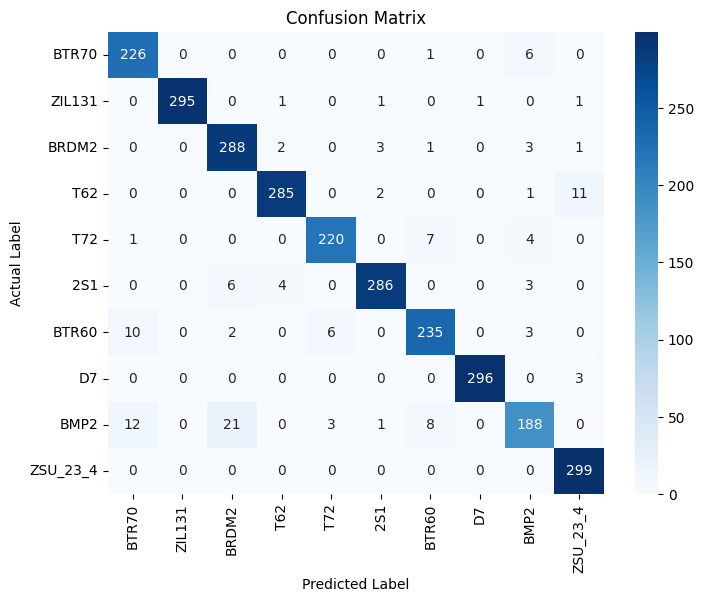

In [19]:
y_predicted = model.predict(x_test)
y_predicted = np.argmax(y_predicted,axis=1)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_predicted)
cm

#Visual Representation of confusion matrix using seaborn heatmap

import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mstarclass_test, yticklabels=mstarclass_test)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


##Previous Model Loadings

In [20]:
Best_model = tf.keras.models.load_model('/kaggle/input/two_stream_cnn_6_model/keras/default/1/two_stream_cnn_6.keras')
Accuracy=Best_model.evaluate(x_test,y_test)[1]
# Accuracy = Best_model.evaluate(x_test,y_test)[1]

# Best_model.summary()

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9784 - loss: 0.0844


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


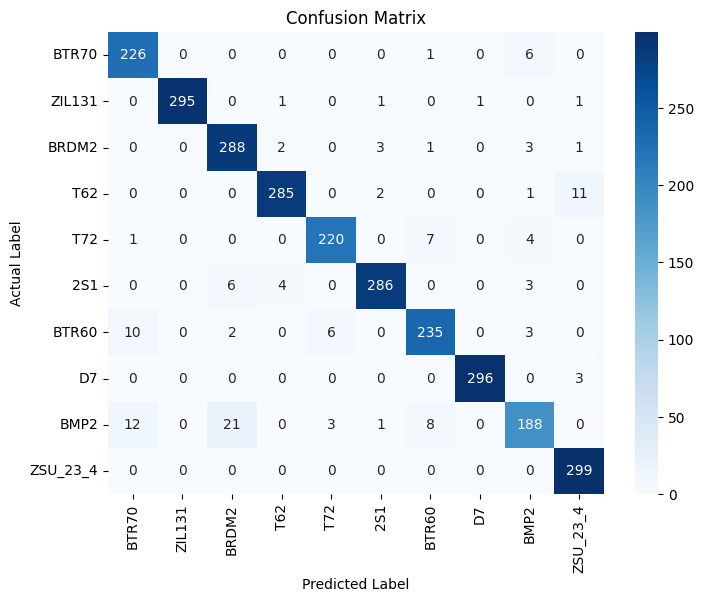

In [21]:
y_predicted = model.predict(x_test)
y_predicted = np.argmax(y_predicted,axis=1)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_predicted)
cm

#Visual Representation of confusion matrix using seaborn heatmap

import matplotlib.pyplot as plt
import seaborn as sns
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=mstarclass_test, yticklabels=mstarclass_test)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_predicted,target_names=mstarclass_test))


              precision    recall  f1-score   support

       BTR70       0.91      0.97      0.94       233
      ZIL131       1.00      0.99      0.99       299
       BRDM2       0.91      0.97      0.94       298
         T62       0.98      0.95      0.96       299
         T72       0.96      0.95      0.95       232
         2S1       0.98      0.96      0.97       299
       BTR60       0.93      0.92      0.93       256
          D7       1.00      0.99      0.99       299
        BMP2       0.90      0.81      0.85       233
    ZSU_23_4       0.95      1.00      0.97       299

    accuracy                           0.95      2747
   macro avg       0.95      0.95      0.95      2747
weighted avg       0.95      0.95      0.95      2747



In [23]:
from sklearn.metrics import cohen_kappa_score
class_accuracy = cm.diagonal() / cm.sum(axis=1)
aa = np.mean(class_accuracy)
print(f'Average Accuracy: {aa}')
print(f'Overall Accuracy: {Accuracy}')
kappa = cohen_kappa_score(y_test, y_predicted)
print(f'Kappa:{kappa}')


Average Accuracy: 0.9495799224841923
Overall Accuracy: 0.9814342856407166
Kappa:0.9477441982483041


In [24]:
from tensorflow.keras.utils import plot_model

# Create a visual representation of the model and save it as an image file
plot_model(Best_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

import shutil

# Move the file to the output directory
shutil.move('model_architecture.png', '/kaggle/working/model_architecture.png')


'/kaggle/working/model_architecture.png'

ROC and AUC Curve

In [25]:
from sklearn.preprocessing import label_binarize


y_true = y_test_categorical
# classes = list(range(10))  
# y_true_bin = label_binarize(y_true, classes=classes)

# print(y_true_bin[:])
# print(y_true[:10])
# print(classes[:])

In [26]:

y_scores = model.predict(x_test)


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [27]:
from sklearn.metrics import roc_curve, auc

fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test_categorical[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


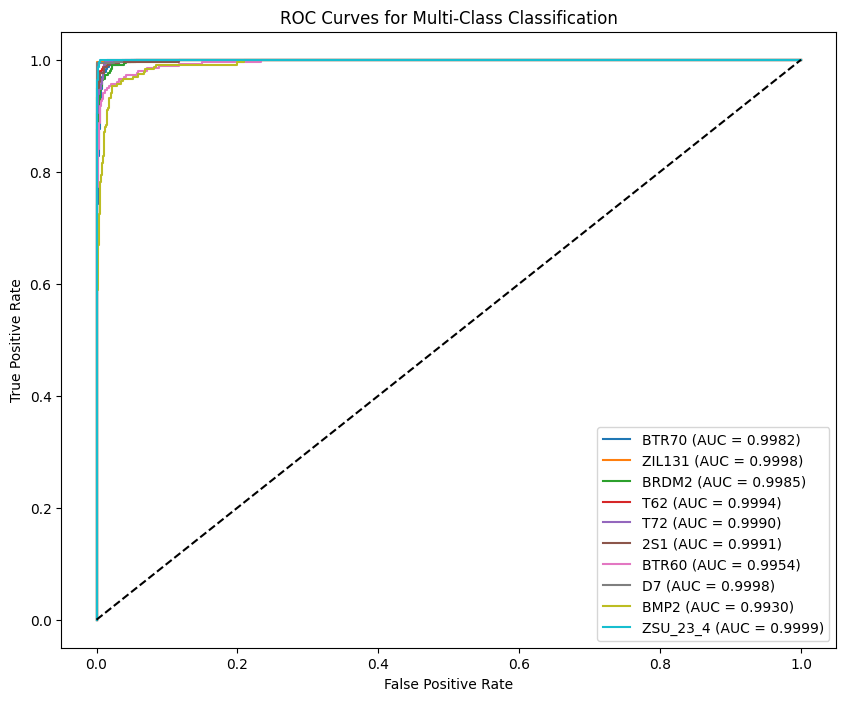

In [28]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{mstarclass_test[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()
